# ML в Биологии
## 11. AB-tests. Part I.

In [3]:
import scipy.stats as sps
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta

from statsmodels.stats.proportion import proportion_confint

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

## Задача 1

*Примечание для обоих профилей*: величину уровня значимости $\alpha$ и минимально необходимой мощности $\beta$ считать стандартными и равными **0.05** и **0.8** соответственно.

### **Профиль биология**


Рассмотрим [данные по медицинским страховкам](https://www.kaggle.com/datasets/gauravduttakiit/medical-insurance-cost?select=Train_Data.csv) из задачи 2 задания по AВ тестам. С помощью формулы для `MDE` оцените количество клиентов страховых компаний, на которых нужно провести AB-тест новых рекомендаций по употреблению витаминов, чтобы задетектировать снижение средней стоимости страховки на 600 долларов. Считайте, что компании не расширяют свою клиентскую базу и данные представляют собой информацию обо всех клиентах, которые могут участвовать в тесте

In [ ]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: Sample_Submission.csv   
  inflating: Test_Data.csv           
  inflating: Train_Data.csv          


In [ ]:
DATA_PATH = 'Train_Data.csv'

data = pd.read_csv(DATA_PATH)['charges'].values
data

array([ 3279.86855   , 21454.49423864,  1720.3537    , ...,
       10602.385     ,  8976.14045154,  7027.69896823])

In [ ]:
data.shape

(3630,)

Зафиксируем параметры уровня значимости, желаемой мощности и величины эффекта.

In [ ]:
alpha = 0.05  # уровень значимости
beta = 0.8  # мощности
mde = 600  # размер эффекта

In [ ]:
def get_mde(alpha, beta, sample_size, var_x, var_y):
    '''Расчитывает MDE

    :param alpha: желаемая ошибка первого рода
    :param beta: желаемая мощность
    :param sample_size: размер выборок
    :param var_x, var_y: дисперсии выборок
    :returns: теоретический MDE
    '''

    q_sum = sps.norm.ppf(1 - alpha) + sps.norm.ppf(beta)
    res = q_sum / np.sqrt(sample_size) * np.sqrt(var_x + var_y)

    return res


def get_sample_size(alpha, beta, mde, var_x, var_y):
    '''Расчитывает размер выборки для детектирование MDE

    :param alpha: желаемая ошибка первого рода
    :param beta: желаемая мощность
    :param mde: необходимый эффект
    :param var_x, var_y: дисперсии выборок
    :returns: необходимый размер выборки
    '''

    q_sum = sps.norm.ppf(1 - alpha) + sps.norm.ppf(beta)
    res = np.ceil((q_sum ** 2) * (var_x + var_y) / (mde * mde)).astype(int)

    return res

Вычислите необходимый размер выборки, воспользовавшись формулами с семинара.

In [ ]:
# сумма квантилей
q = sps.norm.ppf(1 - alpha) + sps.norm.ppf(beta)

var_0 = data.var()
n_0 = get_sample_size(alpha, beta, mde, var_0, var_0)  # размер выборки

n_0, var_0

(3966, 115448286.96320984)

Достаточно ли у вас клиентов для исследования?

**Ответ:** нет


Посмотрите на распределение суммы страховки.

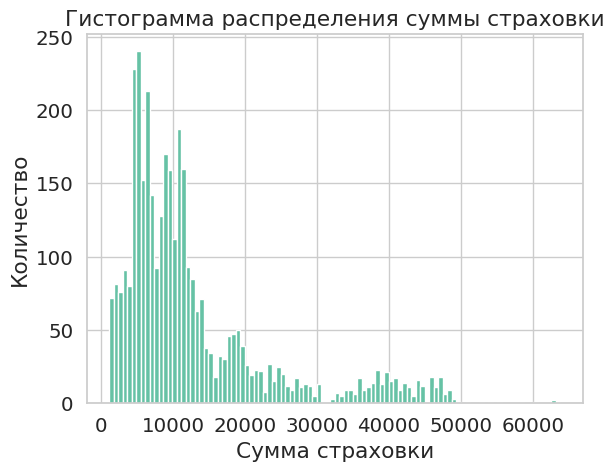

In [ ]:
plt.title(fr'Гистограмма распределения суммы страховки')
plt.hist(data, bins=100)
plt.xlabel('Сумма страховки')
plt.ylabel('Количество');

Видим, что есть выбросы, завышающие нам дисперсию. Выполните фильтрацию данных.

**Внимание! Определять параметры фильтрации выбросов можно только на основе данных ДО эксперимента. Удаление на основании экспериментальным данных может привести к большим ошибкам.**

In [ ]:
data_filtered = data[data<30000]

In [ ]:
data_filtered.shape

(3295,)

Посчитайте, сколько нужно клиентов в данном случае.

In [ ]:
var_1 = data_filtered.var()
n_1 = get_sample_size(alpha, beta, mde, var_1, var_1)

n_1, var_1

(1237, 35988240.2788089)

Как зависит требуемый размер выборки в исследовании от размера эффекта? Постройте график размера выборки от `MDE` для ожидаемой в нашем исследовании дисперсии.

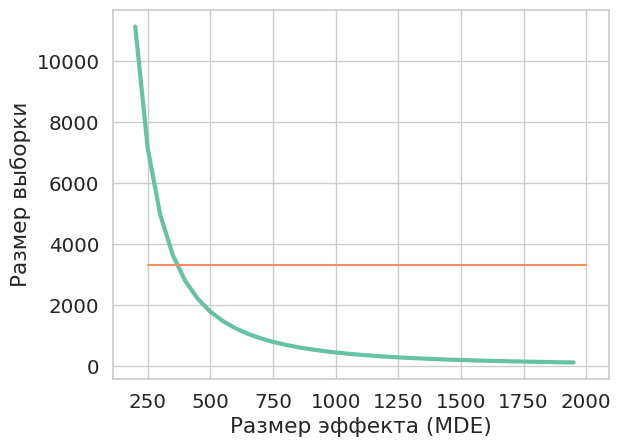

In [ ]:
mde_grid = np.arange(200, 2000, 50)
n = get_sample_size(alpha, beta, mde_grid, var_1, var_1)

plt.plot(mde_grid, n, lw=3)
plt.plot((250, 2000), (data_filtered.shape[0], data_filtered.shape[0]))
plt.xlabel('Размер эффекта (MDE)')
plt.ylabel('Размер выборки');

Какой минимальный эффект можно зафиксировать с нашей выборкой?

**Ответ:**

Мы удалили выбросы, и теперь размер выборки соответствует нашим требованиям.

На графике заметно, что с уменьшением размера выборки минимально детектируемый эффект (MDE) увеличивается, причем зависимость напоминает гиперболу.

Также из графика видно, что при текущем размере выборки MDE составляет около 400 долларов.

**Итоговый вывод по задаче:**

После фильтрации выбросов размер выборки стал достаточным для проведения эксперимента. На графике видно, что минимальный детектируемый эффект (MDE) при текущем размере выборки составляет около 400 долларов, что меньше целевого значения в 600 долларов. Таким образом, эксперимента достаточно для проверки гипотезы.

## Задача 2

Выведите формулу `MDE` для относительного t-test. Рассмотрите случаи односторонней и двусторонней гипотез.

**Ответ:**

Параметр несмещенности:
$$\lambda = \delta \sqrt{\frac{n}{2 \sigma^2}} = z_{\alpha} + z_{1 - \beta} \; , где $$

- $\sigma$ - общее стандартное отклонение
- $\delta = \mu_2 - \mu_1$ - абсолютная разница средних
- $n$ - размер выборки

Тогда:

$$ \delta = (z_{\alpha} + z_{1 - \beta}) \cdot \sqrt{\frac{2 \sigma^2}{n}}$$

Относительный эффект:

$$
MDE = \frac{\delta}{\mu_1} = (z_{\alpha} + z_{1 - \beta}) \cdot \frac{\sigma}{\mu_1}\sqrt{\frac{2}{n}}
$$

**Односторонняя гипотеза:**

$$
MDE = (z_{\alpha} + z_{1 - \beta}) \cdot \frac{\sigma}{\mu_1}\sqrt{\frac{2}{n}}
$$

**Двусторонняя гипотеза:**

$$
MDE = (z_{\alpha/2} + z_{1 - \beta}) \cdot \frac{\sigma}{\mu_1}\sqrt{\frac{2}{n}}
$$


## Задача 3


### **Профиль биология**

В одной фармацевтической компании собираются проводить II фазу клинических испытаний нового лекарства, ослабляющего симптомы диабета. Перед командой аналитики стоит задача о корректном проведении AB-тестирования. У вас имеются исторические [данные по пациентам](https://www.kaggle.com/datasets/jillanisofttech/diabetes-disease-updated-dataset?select=diabetes.csv), страдающим диабетом. С помощью них проведите дизайн эксперимента.


Выберите или оцените каким-нибудь способом:

1. Таргет клинических испытаний (первичную контрольную точку): уровень глюкозы, инсулина, толщину кожи и т.д.;

2. Статистический критерий (название / односторонний или двусторонний / связные или независимые выборки);

3. Размеры A и B групп;

4. Желаемый минимальный детектируемый эффект;

5. Мощность критерия.

Обоснуйте свой выбор в каждом из пунктов.

Все ли полученные показатели вас устраивают? Если нет, то какие могут быть способы их улучшить?

*Примечание.* Если кажется, что информации недостаточно, сделайте свои дополнительные предположения, коррелирующие с реальностью, и работайте с ними.


Для выбранного критерия проведите АА-тест по историческим данным. Если исторических данных оказалось недостаточно для вашей модели, придумайте способ решения проблемы.

In [1]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: diabetes.csv            


In [4]:
DATA_PATH = 'diabetes.csv'

data = pd.read_csv(DATA_PATH)
data = data[data['Outcome']==1]
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
2,8,183,64,0,0,23.3,0.672,32,1
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
...,...,...,...,...,...,...,...,...,...
755,1,128,88,39,110,36.5,1.057,37,1
757,0,123,72,0,0,36.3,0.258,52,1
759,6,190,92,0,0,35.5,0.278,66,1
761,9,170,74,31,0,44.0,0.403,43,1


Выберите, обоснуйте и визуализируйте:

> Таргет клинических испытаний (первичную контрольную точку): уровень глюкозы, инсулина, толщину кожи и тд.;

**Ответ:**

Целевым показателем является уровень глюкозы, так как он наиболее точно отражает эффективность препарата при лечении диабета.

Посмотрите на распределение значений выбранного таргета.

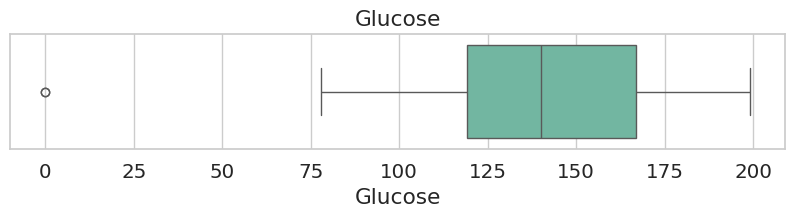

In [5]:
plt.figure(figsize=(10, 1.5))
sns.boxplot(data['Glucose'], orient='h')
plt.title('Glucose')
plt.show()

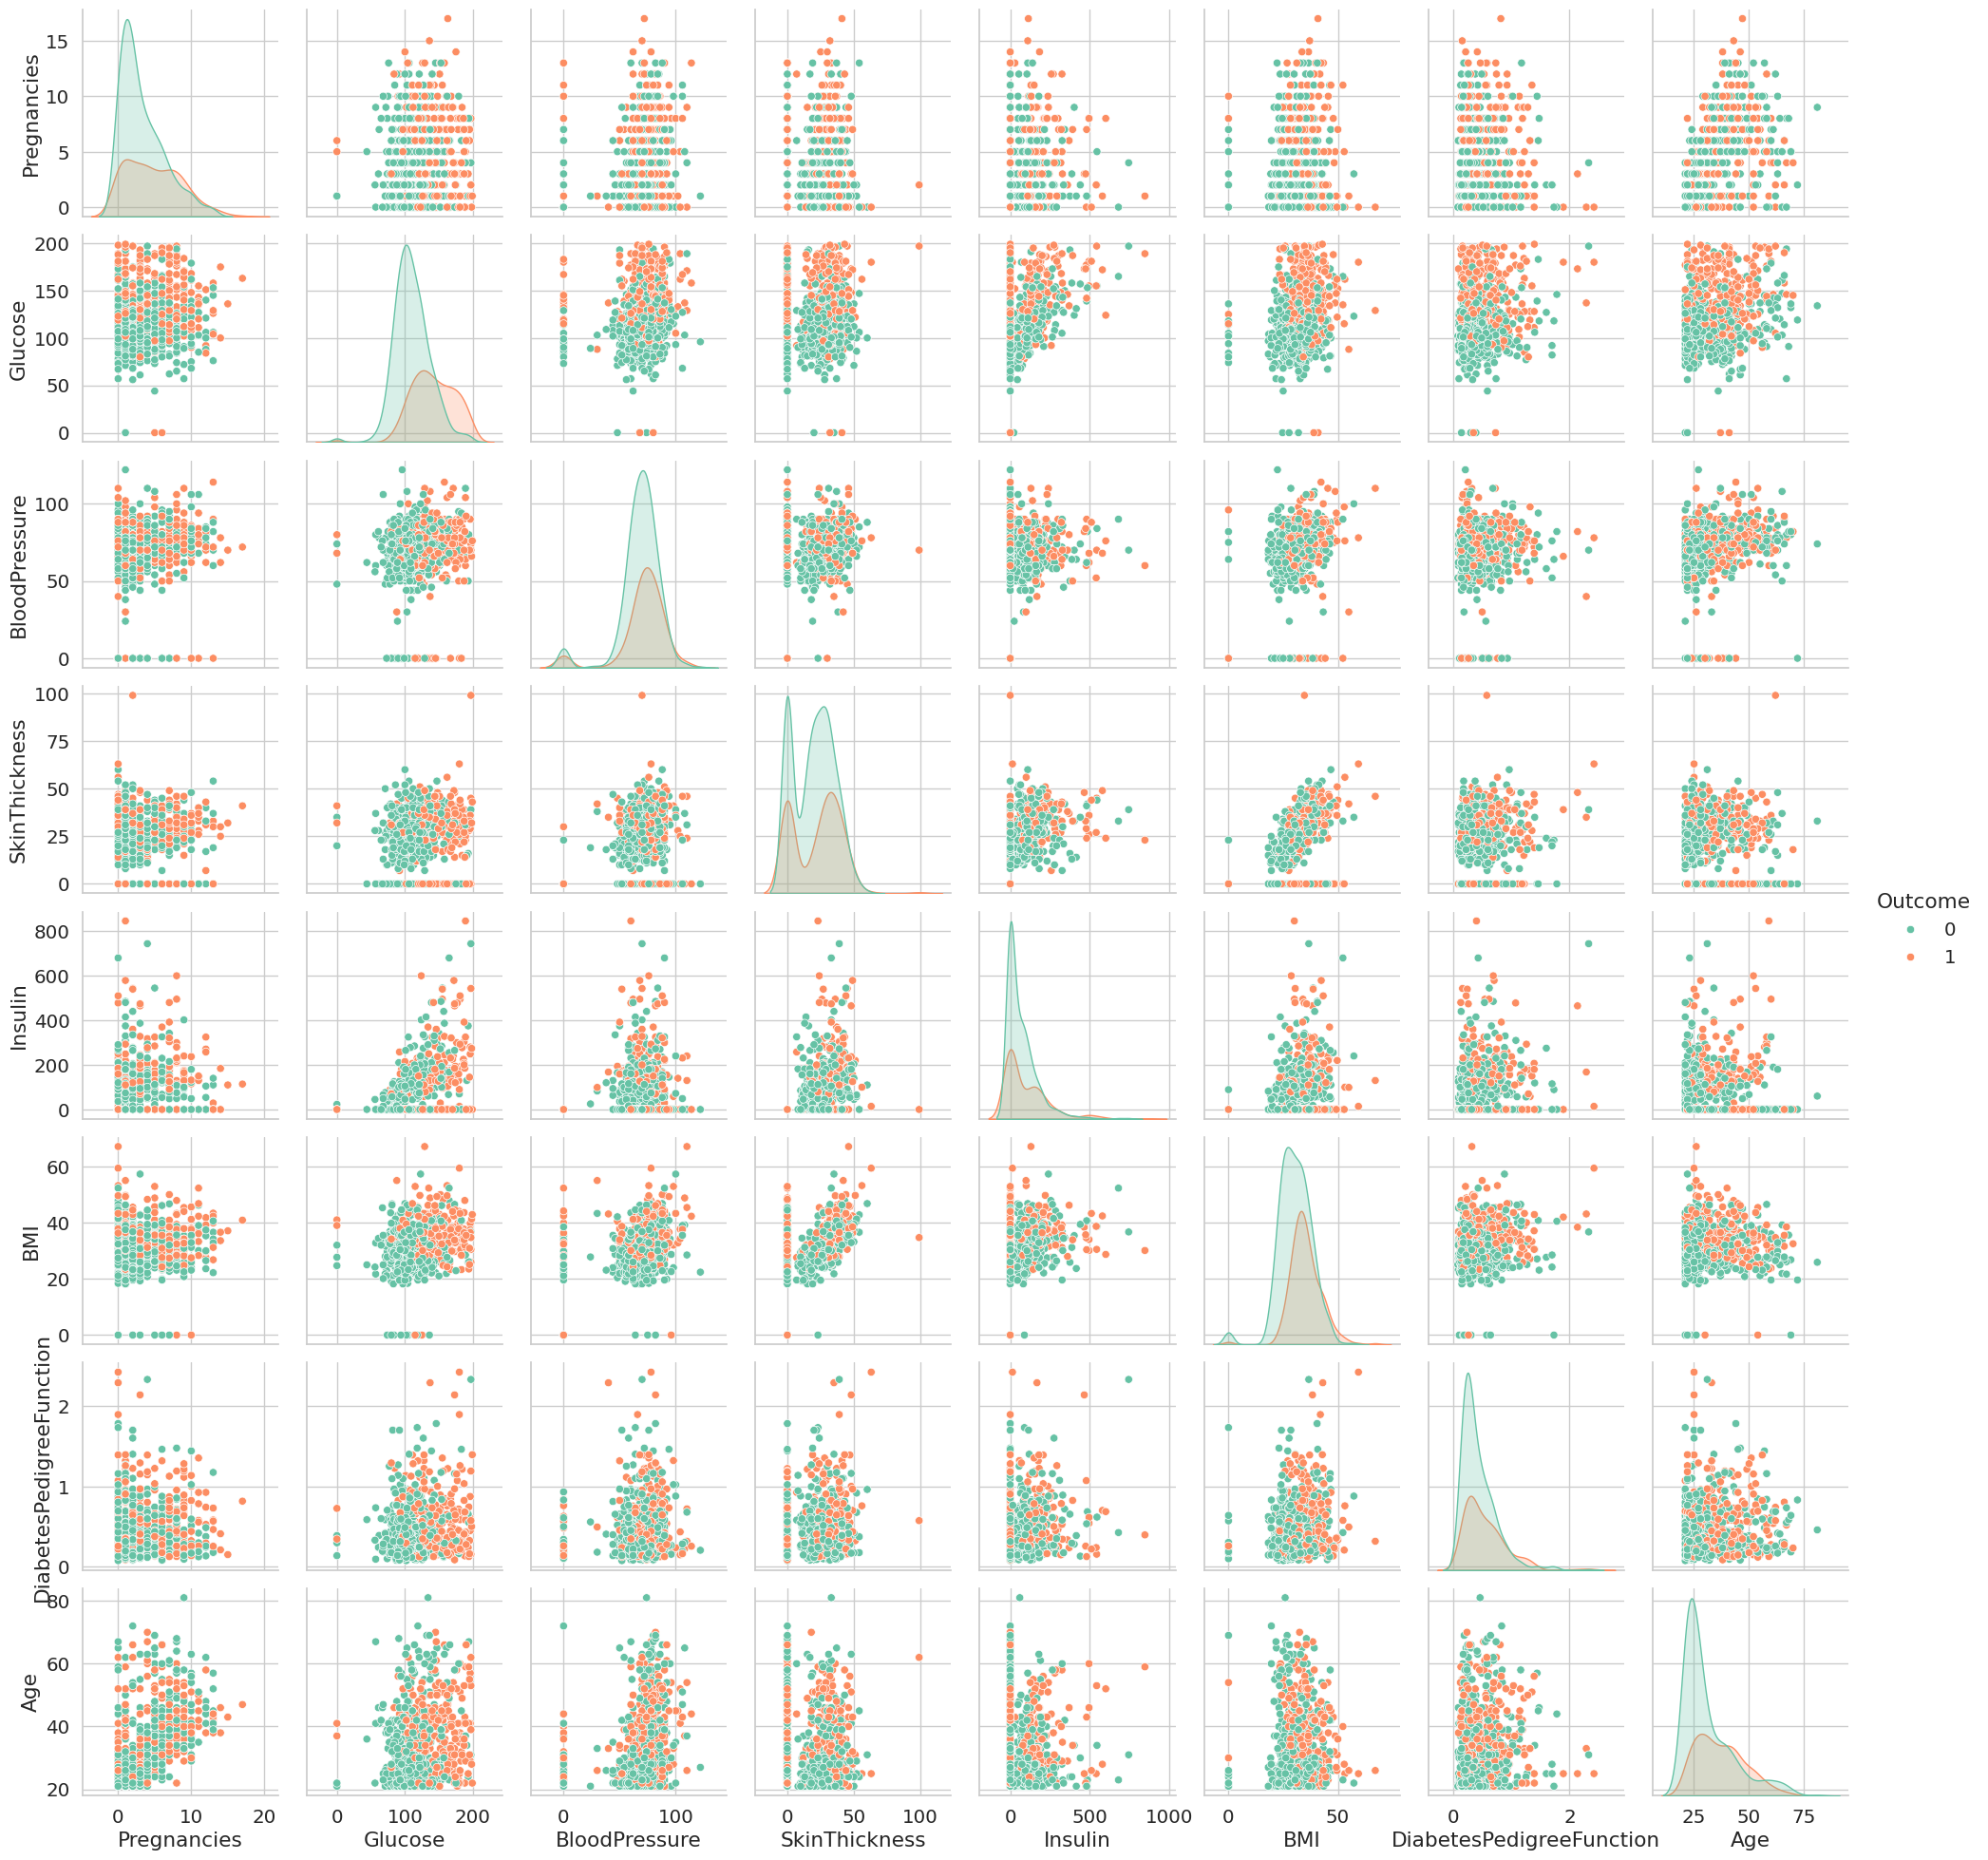

In [6]:
data1 = pd.read_csv(DATA_PATH)
sns.pairplot(data1, hue='Outcome')

> Статистический критерий (название / абсолютный или относительный / односторонний или двусторонний / связные или независимые выборки);

**Ответ:**

Для сравнения средних значений используем t-критерий, поскольку уровень глюкозы является количественной переменной. Мы оцениваем относительный эффект, так как важно снижение уровня глюкозы относительно исходного состояния. Выбираем односторонний тест, так как нас интересует только снижение уровня глюкозы (улучшение). Выборки рассматриваются как независимые, поскольку группы A и B не пересекаются.

> Мощность критерия

**Ответ:**

$\beta$  = 0.8

> Желаемый минимальный детектируемый эффект:

MDE = 10%

> Размер А и В групп.

Для расчета размера выборки необходимо задать следующие параметры:

- Уровень значимости $\alpha$: 0.05
- Мощность $\beta$ 0.8 .
- MDE
- Оценка дисперсии уровня глюкозы.

Будем подбирать по рассмотренной на семинаре таблице `MDE`-мощность-размер выборки

In [7]:
def get_mde(alpha, beta, sample_size, var_R, two_sided=False):
    '''Расcчитывает MDE

    Аргументы:
    alpha -- желаемая ошибка первого рода
    beta -- желаемая мощность
    sample_size -- размер выборок
    var_R -- дисперсии выборок
    two_sided -- двусторонний или односторонний тест

    Возвращает:
    mde -- теоретический MDE
    '''

    if two_sided:
        z_alpha = sps.norm.ppf(1 - alpha / 2)
    else:
        z_alpha = sps.norm.ppf(1 - alpha)
    z_beta = sps.norm.ppf(beta)
    q_sum = z_alpha + z_beta
    mde = q_sum / np.sqrt(sample_size) * np.sqrt(2 * var_R)
    return mde


def get_sample_size(alpha, beta, mde, var_R, two_sided=False):
    '''Расcчитывает размер выборки для детектирование MDE

    Аргументы:
    alpha -- желаемая ошибка первого рода
    beta -- желаемая мощность
    mde -- необходимый эффект
    var_R -- дисперсии выборок
    two_sided -- двусторонний или односторонний тест

    Возвращает:
    n -- теоретический минимальный размер выборки
    '''

    if two_sided:
        z_alpha = sps.norm.ppf(1 - alpha / 2)
    else:
        z_alpha = sps.norm.ppf(1 - alpha)
    z_beta = sps.norm.ppf(beta)
    q_sum = z_alpha + z_beta
    n = np.ceil((q_sum ** 2) * 2 * var_R / (mde ** 2)).astype(int)
    return n

In [14]:
mde_grid = np.arange(0.01, 0.1, 0.01).reshape(-1, 1)  # относительный MDE
beta_grid = np.arange(0.6, 1, 0.05)  # мощность
alpha = 0.05 # выбранный теоретический уровень значимости
var = data['Glucose'].var()  # дисперсия, расчет зависит от выбранного типа теста: абсолютный или относительный
mean_glucose = data['Glucose'].mean()  # среднее значение уровня глюкозы

mde_grid_abs = mde_grid * mean_glucose

sample_sizes = np.zeros((len(mde_grid), len(beta_grid)))

for i, mde in enumerate(mde_grid_abs):
    for j, beta in enumerate(beta_grid):
        n = get_sample_size(alpha, beta, mde, var, two_sided=False)
        sample_sizes[i, j] = n

sample_sizes_df = pd.DataFrame(sample_sizes, index=mde_grid.flatten(), columns=beta_grid)
sample_sizes_df.index.name = 'MDE'
sample_sizes_df.columns.name = 'Power'

sample_sizes_df

Power,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
MDE,,,,,,,,
0.01,3685.0,4215.0,4812.0,5501.0,6322.0,7352.0,8757.0,11066.0
0.02,922.0,1054.0,1203.0,1376.0,1581.0,1838.0,2190.0,2767.0
0.03,410.0,469.0,535.0,612.0,703.0,817.0,973.0,1230.0
0.04,231.0,264.0,301.0,344.0,396.0,460.0,548.0,692.0
0.05,148.0,169.0,193.0,221.0,253.0,295.0,351.0,443.0
0.06,103.0,118.0,134.0,153.0,176.0,205.0,244.0,308.0
0.07,76.0,87.0,99.0,113.0,130.0,151.0,179.0,226.0
0.08,58.0,66.0,76.0,86.0,99.0,115.0,137.0,173.0
0.09,46.0,53.0,60.0,68.0,79.0,91.0,109.0,137.0


**Ответ:**

Для необходимого размера выборки, равного 253, после фильтрации данных с условием `Outcome == 1`, в датасете остается всего 268 наблюдений. Это делает невозможным формирование двух независимых выборок размером 253 без замены, так как доступное количество данных недостаточно. В такой ситуации можно рассмотреть использование всего датасета без фильтрации по `Outcome`.

Для выбранного критерия проведите АА-тест по историческим данным. Если исторических данных оказалось недостаточно для вашей модели, придумайте способ решения проблемы.

In [15]:
DATA_PATH = './diabetes.csv'
data = pd.read_csv(DATA_PATH)
data_glucose = data['Glucose'].dropna().values

In [16]:
sample_size = 253
alpha = 0.05

In [32]:
p_vals = []

for i in tqdm(range(2000)):

    sample1, sample2 = np.random.choice(data_glucose, (2, sample_size), replace=False)

    t_stat, p_val = sps.ttest_ind(sample1, sample2, equal_var=False)
    p_vals.append(p_val)

p_vals = np.array(p_vals)

100%|██████████| 2000/2000 [00:04<00:00, 450.69it/s]


In [33]:
def draw_interval(
    real_alpha, left_bound, right_bound,
    alpha=0.05, new_fig=True
):
    '''
    Отрисовка интервала для вероятности отвержения критерия

    Аргументы:
    real_alpha -- оценка реального уровня значимости
    left_bound, right_bound -- границы дов. интервала
    alpha -- теоретический уровень значимости
    new_fig -- coздавать ли новую matplotlib figure
    '''

    if new_fig:
        plt.figure(figsize=(7, 3.5))

    plt.hlines(0, 0, 1,
               color='black', lw=2, alpha=0.6)
    plt.vlines(alpha, -1, 1,
               color='red', lw=2, linestyle='--', alpha=0.6)
    plt.fill_between([left_bound, right_bound], [0.1]*2, [-0.1]*2,
                     color='green', alpha=0.6)
    plt.scatter(real_alpha, 0, s=300, marker='*', color='red')
    plt.xlim((min(alpha, left_bound)-1e-3, max(alpha, right_bound)+1e-3))
    plt.title(
            f'Доля отвержений = {100*real_alpha:.2f}%, '
            f'интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)'
        )
    plt.ylim((-0.5, 0.5))
    plt.yticks([])

Реальный уровень значимости: 0.05


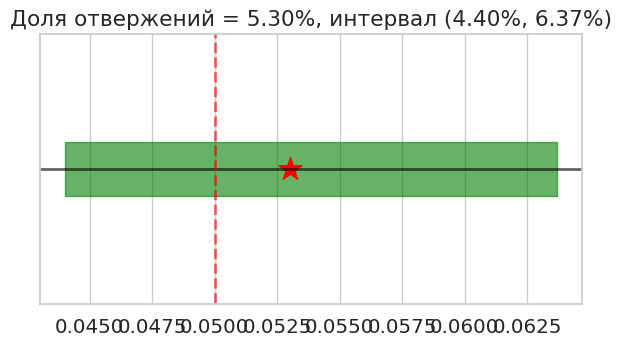

In [34]:
real_alpha = (p_vals < alpha).mean()
print(f'Реальный уровень значимости: {real_alpha.round(2)}')
left_alpha, right_alpha = proportion_confint((p_vals < alpha).sum(), len(p_vals), method='wilson')
draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)

Посмотрите также на гистограмму p-value

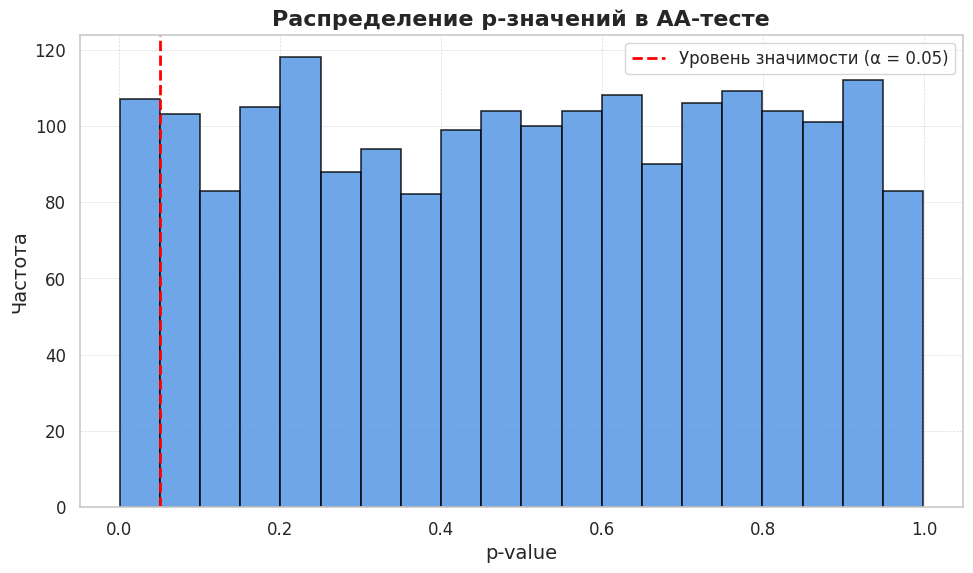

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(
    p_vals, bins=20, alpha=0.8, color='#4A90E2', edgecolor='black', linewidth=1.2
)
plt.axvline(
    alpha, color='red', linestyle='--', linewidth=2, label=f"Уровень значимости (α = {alpha})"
)
plt.title("Распределение p-значений в АА-тесте", fontsize=16, fontweight='bold')
plt.xlabel("p-value", fontsize=14)
plt.ylabel("Частота", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Какие выводы о валидности выбранного критерия вы можете сделать?

**Ответ:**

Фактический уровень значимости составил 5.30%, что близко к теоретическому значению 5%. Это подтверждает, что тест корректно контролирует вероятность ошибки первого рода. Кроме того, доверительный интервал уровня значимости (4.40%−6.37%) включает целевое значение 5%, что дополнительно свидетельствует о корректности теста. Таким образом, критерий можно считать валидным для анализа данных в данной задаче.

Проверьте также мощность критерия на выбранном `MDE`.


In [35]:
pvals = []

for _ in tqdm(range(2000)):
    sample1 = np.random.choice(data_glucose, sample_size, replace=False)
    sample2 = np.random.choice(data_glucose, sample_size, replace=False)

    sample2 = sample2 + mde
    sample2 += sps.norm.rvs(size=len(sample2), scale=10)

    t_stat, p_val = sps.ttest_ind(sample1, sample2, equal_var=False)
    pvals.append(p_val)

pvals = np.array(pvals)

100%|██████████| 2000/2000 [00:05<00:00, 377.07it/s]


In [36]:
print(f'Реальная мощность критерия: {(pvals < alpha).mean().round(3)}')

Реальная мощность критерия: 0.998


**Итоговый вывод по задаче:**

При текущих параметрах эксперимента (размер выборки, уровень шума, MDE) реальная мощность критерия составляет 0.998, что свидетельствует о высокой способности теста обнаруживать эффект. Это означает, что выбранные параметры эксперимента обеспечивают достаточную чувствительность для выявления значимых изменений. Корректировка параметров, таких как размер выборки или уровень шума, в данном случае не требуется.